# Probabilistic Deep Learning - Normalizing Flows

Normalizing flows construct a bijection (one-to-one and onto) from a base distribution to a target distribution. Bijections are typically constructed as a chain of simple bijections.  They can be used to learn the distributions of complex data sets. Under the hood, maximum likelihood is used to learn the parameters of the bijections.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Transforming uniform(0, 2) to its square

In [36]:
bijector = tfb.Square()
base = tfd.Uniform(0, 2.0)
dist = tfd.TransformedDistribution(
    distribution=base,
    bijector=bijector
)

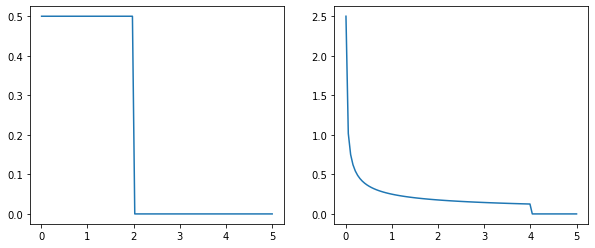

In [44]:
xs = np.linspace(1e-2, 5, 100)
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(xs, base.prob(xs))
axes[1].plot(xs, dist.prob(xs))
pass

In [38]:
dist.cdf(3).numpy()

0.8660254

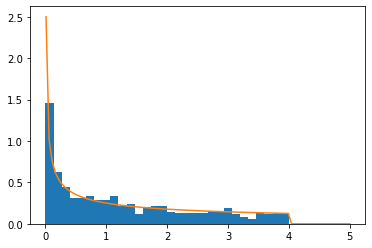

In [47]:
zs = dist.sample(1000).numpy()
plt.hist(zs, 30, density=True)
plt.plot(xs, dist.prob(xs))
pass

### Transforming normal(0, 1) to normal(5, 0.2)

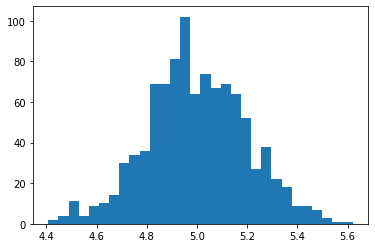

In [5]:
n = 1000
X = tfd.Normal(loc=5, scale=0.2).sample(n)
X = X.numpy().reshape([-1,1])
plt.hist(X, 30)
pass

In [19]:
@tf.function
def train_step(data, dist, opt):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(data))
        grad = tape.gradient(
            loss,
            dist.trainable_variables
        )
    opt.apply_gradients(
        zip(grad, dist.trainable_variables)
    )  
    return loss    

def nf(data, base, bijector, niter, opt):
    """Run normalizing flow."""
    
    dist = tfd.TransformedDistribution(
        distribution=base,
        bijector=bijector
    )
    
    for i in range(niter):
        loss = train_step(data, dist, opt) 
        
        if i % (niter//10) == 0:
            print(i, 'NLL', loss.numpy())
        
    return dist

In [20]:
a = tf.Variable(1.0)
b = tf.Variable(0.0)
bijector= tfb.Shift(shift=b)(tfb.Scale(scale=a))
base = tfd.Normal(loc=0, scale=1)
niter = 2001
opt = tf.keras.optimizers.Adam(lr=1e-1)
dist = nf(X, base, bijector, niter, opt)

0 NLL 13.438855
200 NLL 0.2579931
400 NLL -0.19114098
600 NLL -0.19114102
800 NLL -0.19114096
1000 NLL -0.19114096
1200 NLL -0.19114096
1400 NLL -0.19114096
1600 NLL -0.19114096
1800 NLL -0.19114096
2000 NLL -0.19114096


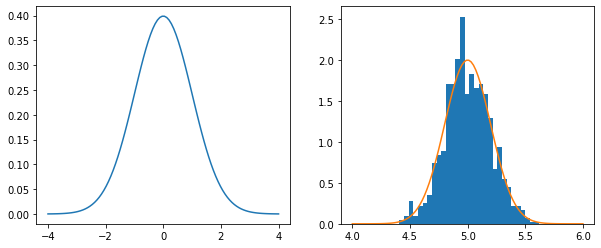

In [27]:
xs1 = np.linspace(-4, 4, 100)
xs2 = np.linspace(4, 6, 100)
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(xs1, base.prob(xs1))
axes[1].hist(X, 30, density=True)
axes[1].plot(xs2, dist.prob(xs2))
pass

### Transforming normal(0, 1) to fit complicated density

In [9]:
url = 'https://bit.ly/3skOrEC'
df = pd.read_csv(url, sep='\t')
df.head(3)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74


In [10]:
df.waiting = df.waiting.astype('float32')

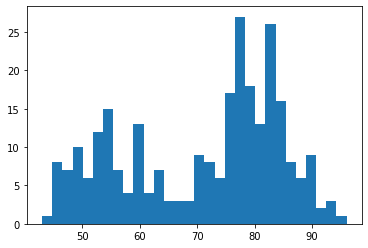

In [11]:
plt.hist(df.waiting, 30)
pass

In [29]:
@tf.function
def train_step2(data, dist, opt):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(data))
        grad = tape.gradient(
            loss,
            dist.trainable_variables
        )
    opt.apply_gradients(
        zip(grad, dist.trainable_variables)
    )  
    return loss    

def nf2(data, base, bijector, niter, opt):
    """Run normalizing flow."""
    
    dist = tfd.TransformedDistribution(
        distribution=base,
        bijector=bijector
    )
    
    for i in range(niter):
        loss = train_step2(data, dist, opt) 
        
        if i % (niter//10) == 0:
            print(i, 'NLL', loss.numpy())
        
    return dist

In [30]:
n_block = 5
bijectors = []
for i in range(n_block):
    shift = tf.Variable(0.0)
    scale = tf.Variable(1.0)
    bijectors.append(tfb.Shift(shift=shift)(tfb.Scale(scale=scale)))
    
    skewness = tf.Variable(0.0)
    tailweight = tf.Variable(1.0)
    bijectors.append(tfb.SinhArcsinh(skewness=skewness, tailweight=tailweight))    
bijector = tfb.Chain(bijectors)
base = tfd.Normal(loc=0, scale=1)
niter = 20001
opt = tf.keras.optimizers.Adam()
dist = nf2(df.waiting, base, bijector, niter, opt)

0 NLL 2606.1875
2000 NLL 9.000694
4000 NLL 5.310574
6000 NLL 4.6371117
8000 NLL 4.3333497
10000 NLL 4.11877
12000 NLL 4.0503807
14000 NLL 3.9616282
16000 NLL 3.901851
18000 NLL 3.843548
20000 NLL 3.823726


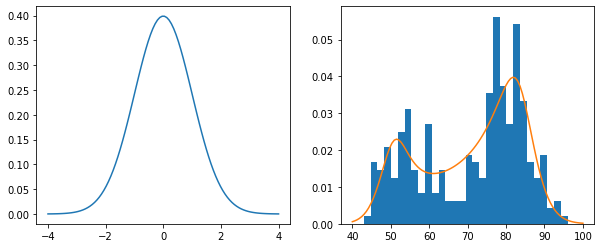

In [31]:
xs = np.linspace(-4, 4, 100)
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(xs, base.prob(xs))
xp = np.linspace(40, 100, 100)
axes[1].hist(df.waiting, 30, density=True)
axes[1].plot(xp, dist.prob(xp))
pass